In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls
import copy 
import os
import time
#import f90nml

In [2]:
%matplotlib notebook

In [3]:
def flatten(u):
    Nx, Ny = np.shape(u)
    return np.reshape(u, Nx*Ny)
def unflatten(uflat, Nx, Ny):
    return np.reshape(uflat, (Ny, Nx))

In [4]:
def odefuncflat(uflat, t, params):
    Nx = params[2]
    Ny = params[3]
    u = unflatten(uflat, Nx, Ny)
    
    du=odefunc(u, t, params)
    duflat = flatten(du)
    return duflat 

In [5]:
def odefunc(u, t, params):
    
    Nx,Ny = np.shape(u)
    dux = np.zeros((Nx, Ny))
    duy = np.zeros((Nx, Ny))
    du = np.zeros((Nx, Ny))
    
    Fx = params[0]
    Fy = params[1]
    
  # Compute u at inner mesh points
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
                #This takes care of the inner part of the 2D array but does not yet account for all periodic boundry condiitons
                
                dux[i, j] = (u[i-1, j] - 2*u[i, j] + u[i+1, j])*Fx
                duy[i, j] = (u[i, j-1] - 2*u[i, j] + u[i, j+1])*Fy
            
                
                
  # Compute u for top and bottom in x mesh points
    for j in range(1, Ny-1):
        duy[0, j]=(u[0, j-1] - 2*u[0, j] + u[0, j+1])*Fy
        duy[-1, j]=(u[-1, j-1] - 2*u[-1, j] + u[-1, j+1])*Fy
        
        dux[0, j]=(u[-1, j] - 2*u[0, j] + u[1, j])*Fx
        dux[-1, j]=(u[-2, j] - 2*u[-1, j] + u[0, j])*Fx
        
    #compute u for left and right in y mesh points
    for i in range(1, Nx-1):
        dux[i, 0]=(u[i-1,0] - 2*u[i, 0] + u[i+1, 0])*Fx
        dux[i, -1]=(u[i-1, -1] - 2*u[i, -1] + u[i+1, -1])*Fx
        
        duy[i, 0]=(u[i, -1] - 2*u[i, 0] + u[i, 1])*Fy
        duy[i, -1]=(u[i, -2] - 2*u[i, -1] + u[i, 0])*Fy
        
    #compute the left top corner of grid
    dux[0,0]=(u[-1,0] - 2*u[0, 0] + u[1, 0])*Fx
    duy[0,0]=(u[0,-1] - 2*u[0, 0] + u[0, 1])*Fy
    
    #compute the left bottom corner of grid
    dux[-1,0]=(u[-2,0] - 2*u[-1, 0] + u[0, 0])*Fx
    duy[-1,0]=(u[-1,-1] - 2*u[-1, 0] + u[-1, 1])*Fy
    
    #compute the right top corner of grid
    dux[0,-1]=(u[-1,-1] - 2*u[0, -1] + u[1, -1])*Fx
    duy[0,-1]=(u[0,-2] - 2*u[0, -1] + u[0, 0])*Fy
    
    #compute the right bottom corner of grid
    dux[-1,-1]=(u[-2,-1] - 2*u[-1, -1] + u[0, -1])*Fx
    duy[-1,-1]=(u[-1,-2] - 2*u[-1, -1] + u[-1, 0])*Fy

    #combine dux and duy values
    du = dux + duy

    return du

In [6]:
def makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid):
# x0 = 50
# y0 = 50
# Sigma = 5
# volume = 1
    bump = 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))*volume
    xgrid1 = xgrid-(Lx+dx)
    ygrid1 = ygrid-(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid1 - x0)**2 + (ygrid1 - y0)**2)/(2*Sigma**2))*volume
    
    xgrid2 = xgrid-(Lx+dx)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid2 - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))*volume
    
    xgrid3 = xgrid-(Lx+dx)
    ygrid3 = ygrid +(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid3 - x0)**2 + (ygrid3 - y0)**2)/(2*Sigma**2))*volume
    
    ygrid4 = ygrid-(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid - x0)**2 + (ygrid4 - y0)**2)/(2*Sigma**2))*volume
    
    ygrid6 = ygrid+(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid - x0)**2 + (ygrid6 - y0)**2)/(2*Sigma**2))*volume
    
    xgrid7 = xgrid+(Lx+dx)
    ygrid7 = ygrid-(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid7 - x0)**2 + (ygrid7 - y0)**2)/(2*Sigma**2))*volume
    
    xgrid8 = xgrid+(Lx+dx)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid8 - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))*volume    
    
    xgrid9 = xgrid+(Lx+dx)
    ygrid9 = ygrid+(Ly+dy)
    bump += 1/(2*np.pi*Sigma**2)*np.exp(-((xgrid9 - x0)**2 + (ygrid9 - y0)**2)/(2*Sigma**2))*volume
    
    
    return bump
# x0 = 50
# y0 = 100
# Sigma = 5
# volume = 1
# bump = makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid)
# ax = plt.figure().gca(projection='3d')
# ax.plot_surface(xgrid, ygrid, bump)
# ax.set_xlabel('x')
# ax.set_ylabel('y')

In [7]:
# Define the physical size of the box
Lx = 100
Ly = 100

# Digital resolution of the box
Nx = 101
Ny = 100

# x-y grid
x = np.linspace(0, Lx, Nx) # mesh points in space
y = np.linspace(0, Ly, Ny) 
dx = x[1] - x[0]
dy = y[1] - y[0]

# Diffusion coefficients
a_old = 0.00002
D_x = a_old*Lx**2
D_y = a_old*Ly**2 

# Diffusion coefficients scaled for integration
Fx = D_x/dx**2
Fy = D_y/dy**2

# Bundle parameters for ODE solver
params = [Fx,Fy, Nx, Ny]
 
# Lay out the x-y grid
xgrid, ygrid = np.meshgrid(x, y)

In [8]:
# Properties of the gaussian
Sigma = 4
volume = 100

# Report something about T
Sigmaprime = 2*Sigma
Tdouble = (Sigmaprime**2 - Sigma**2)/(2*D_x)
print("Time to doubling width = ", Tdouble)

# Specify number of bumps we want
Nbumps = 50
print('Number of bumps = ', Nbumps)

# Time between bumps
T = 10
t = np.linspace(0,T,2)

# Other interesting info
T0 = Sigma**2/(2*D_x)
Sigmalast = np.sqrt(2*D_x*(T*Nbumps+T0))

print('Time between bumps =', T)
print('Time from start to finish =', T*Nbumps)
print('Width of first bump at end of simulation = ', Sigmalast)

Time to doubling width =  120.0
Number of bumps =  50
Time between bumps = 10
Time from start to finish = 500
Width of first bump at end of simulation =  14.6969384567


In [9]:
# Initialize u
u = np.zeros((Ny, Nx))

# Loop over bumps
for i in range(Nbumps):
    x0 = np.random.rand()*Lx
    y0 = np.random.rand()*Ly 
    bump = makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid)
    if i==0:
        sum0 = np.sum(bump)
    u += bump
    uflat = flatten(u)
    solflat = odeint(odefuncflat, uflat, t, args = (params,), atol=1e-7)
    sollast = unflatten(solflat[-1], Nx, Ny)
    u = copy.copy(sollast)
    print(i)

# This adds one more
x0 = np.random.rand()*Lx
y0 = np.random.rand()*Ly     
u += makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid)
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
done


<IPython.core.display.Javascript object>


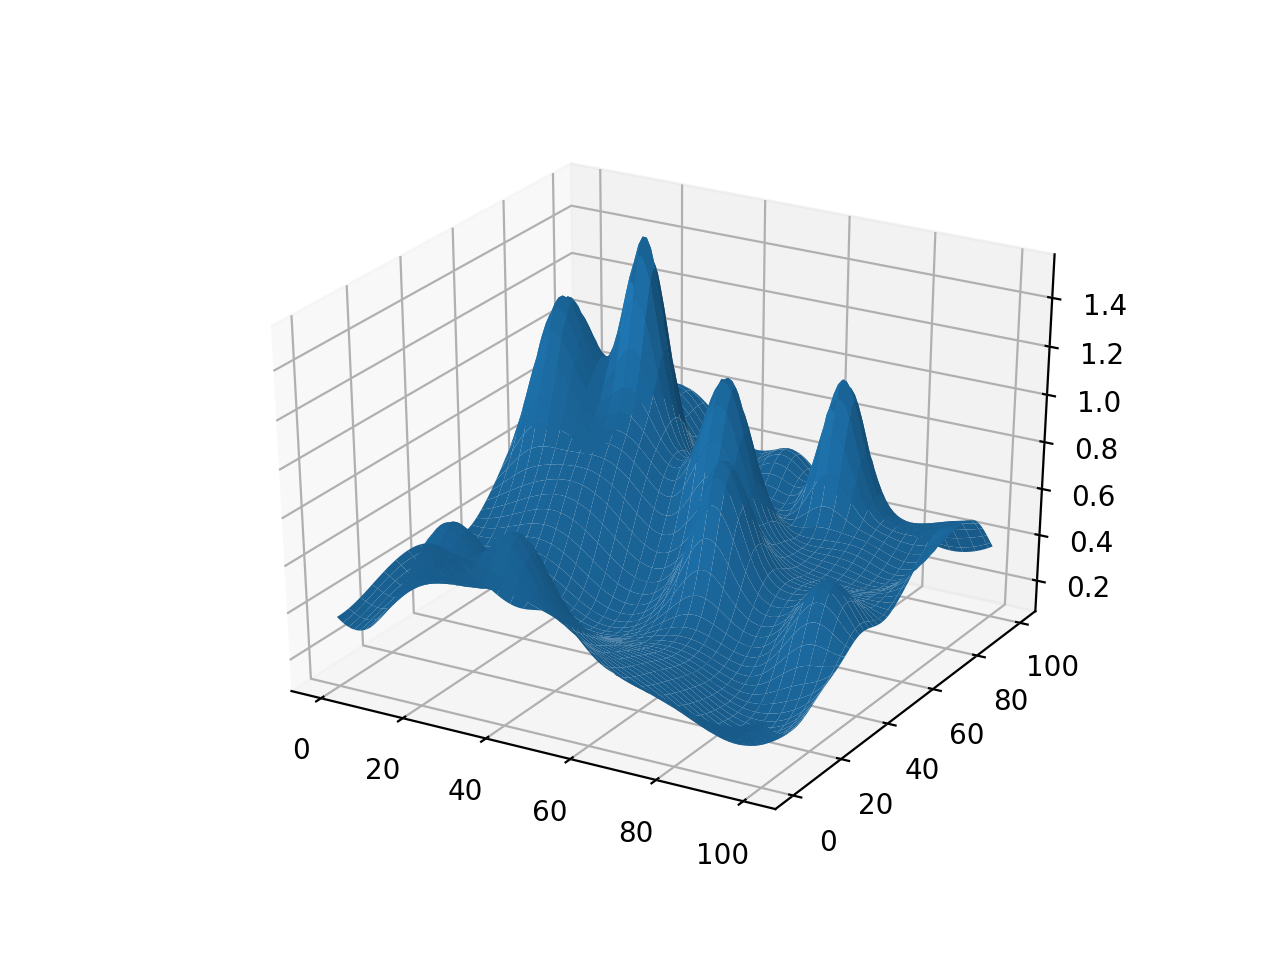

In [10]:
# Plot the surface as a mesh
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)

In [20]:
# get the dimensions 
nx,ny = np.shape(sollast)

# define the bottom of the skirt
bottom = np.min(sollast)- 5


# add a row to beginning 
startrow = np.ones(ny)*bottom; #print(np.shape(startrow))

# add a row to the end
sollast1 = np.vstack ((startrow,sollast,startrow)); 
print(np.shape(sollast1))
sollast2 = np.transpose(sollast1); 
print(np.shape(sollast2))

# add a column to beginning
newcol = np.ones(nx+2)*bottom; #
print(np.shape(newcol))

# add a column to the end
sollast3 = np.vstack ((newcol,sollast2,newcol))
sollast4 = np.transpose (sollast3)

# Update the dimensions
nytot, nxtot = np.shape(sollast4)
print (nxtot,nytot)

(102, 101)
(101, 102)
(102,)
103 102


In [21]:
#saves an individual solution as a stl file
sls.numpy2stl(sollast4, "sollast44.stl", scale = dx*10, solid=False)

Creating top mesh...
